In [1]:
from lbmpy.session import *
from lbmpy.phasefield.scenarios import create_n_phase_model
from pystencils.datahandling import SerialDataHandling
from lbmpy.phasefield.analytical import *
from lbmpy.phasefield.experiments1D import *
from lbmpy.phasefield.analytical import analytic_interface_profile
from functools import partial

## Tanh test

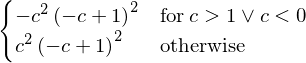

In [2]:
width = 100
f2 = partial(n_phases_correction_function_sign_switch, beta=1)


sc1 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), 
                                                            periodicity=True),
                           f2=f2,
                           num_phases=4, alpha=1)

phaseIdx = 1
init_sharp_interface(sc1, phase_idx=1, inverse=False)
#init_sharp_interface(sc1, phase_idx=0, inverse=True)

sc1.set_pdf_fields_from_macroscopic_values()

f2(sp.Symbol("c"))

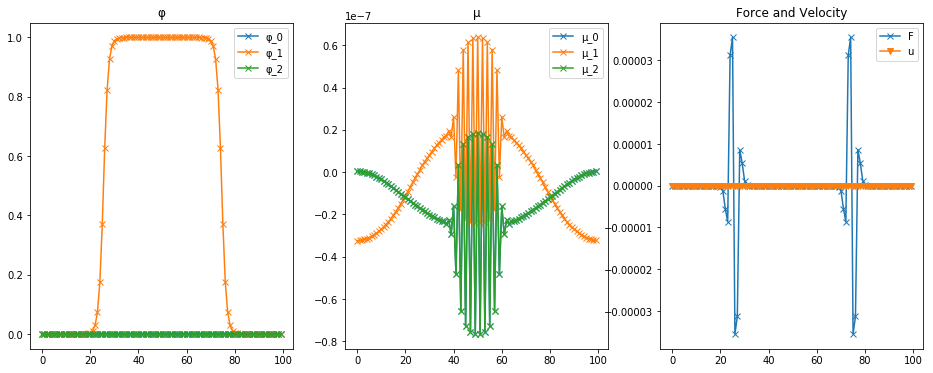

In [3]:
if 'is_test_run' in globals():
    sc1.run(1000)
else:
    sc1.run(100_000)
plot_status(sc1)
sc1.time_steps_run

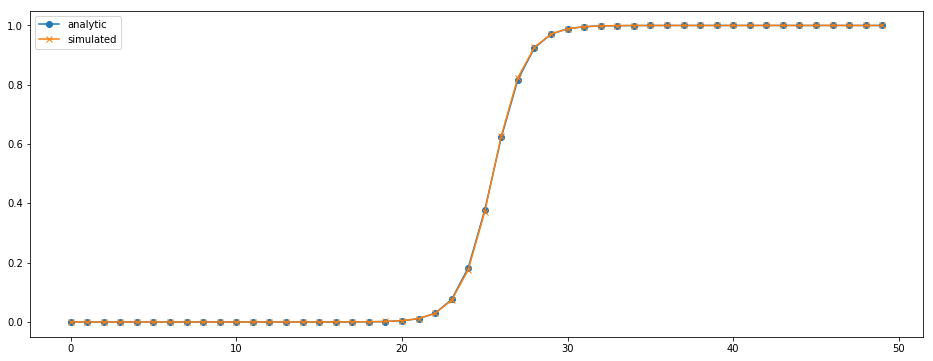

In [4]:
alpha = 1
visWidth = 25
x = np.arange(2 * visWidth) - visWidth
analytic = np.array([analytic_interface_profile(x_i - 0.5, alpha) for x_i in x], dtype=np.float64)

visSlice = make_slice[25 - visWidth:25 + visWidth, 0, phaseIdx]
simulated = sc1.phi_slice(visSlice).copy()

plt.plot(analytic, label='analytic', marker='o')
plt.plot(simulated, label='simulated', marker='x')
plt.legend();

In [5]:
assert not np.isnan(np.max(simulated))

# Phase separation

In [6]:
num_phases = 3
f2 = partial(n_phases_correction_function, power=2, beta=0.001)
ll = create_n_phase_model(data_handling=SerialDataHandling((200, 200), 
                                                            periodicity=True),
                          f2=f2,
                          surface_tensions=lambda i, j: 0.0025/2 if i != j else 0,
                          num_phases=num_phases, alpha=1,
                          cahn_hilliard_relaxation_rates=1.2,
                          optimization={'target': 'gpu'})

In [7]:
ll.set_concentration(make_slice[:, :], [1/num_phases] * ll.num_order_parameters)
φ_arr = ll.data_handling.cpu_arrays['pf_phi']
φ_arr += (np.random.rand(*φ_arr.shape)-0.5) * 0.2
ll.set_pdf_fields_from_macroscopic_values()
#plt.phase_plot_for_step(ll)

In [8]:
f_bulk, f_if = separate_into_bulk_and_interface(ll.free_energy)
φ = sp.symbols("phi_:{}".format(num_phases))
hessian = sp.hessian(f_bulk, φ)

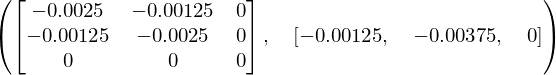

In [9]:
evaluated_hessian = hessian.subs({ f: 1/num_phases for f in φ})
eigenvalues = [a.evalf()  for a,b in evaluated_hessian.eigenvals().items()]
assert any(a < 0 for a in eigenvalues)
evaluated_hessian, eigenvalues

In [10]:
eigenvalues

In [11]:
if 'is_test_run' in globals():
    ll.run(1000)
else:
    for i in range(24):
        ll.run(2_000)
        min_φ, max_φ = np.min(ll.phi[:, :]), np.max(ll.phi[:, :])
        print(i, min_φ, max_φ)
        if max_φ > 0.6:
            break
    assert max_φ > 0.6
    ll.time_steps_run

0 0.28610655901737136 0.38574533140705647
1 0.283708971182857 0.38542379366226814
2 0.27737525687493003 0.3875834110336176
3 0.26743667524125925 0.39169417290369996
4 0.2546379859119067 0.3971101679812658
5 0.23876111373228687 0.4035147117655119
6 0.21954225718115644 0.41081546554212317
7 0.1971502541085478 0.4189466180723286
8 0.17255739304169496 0.4278436664439243
9 0.14760771909058418 0.43743508856384516
10 0.12354706683387104 0.45060517746073125
11 0.10208515792533701 0.4653737116964212
12 0.0845978411284506 0.48178183362228577
13 0.07088806627123448 0.5034911266012848
14 0.060327351687933226 0.5246314660509649
15 0.05218965145635607 0.5443720200667833
16 0.04580494814810558 0.5624163207448445
17 0.04070144973803341 0.5793441950185287
18 0.036188599078823845 0.5963215158797522
19 0.032713912036045 0.6122861731926151


In [12]:
ll.run(4_000)
np.min(ll.phi[:, :]), np.max(ll.phi[:, :])

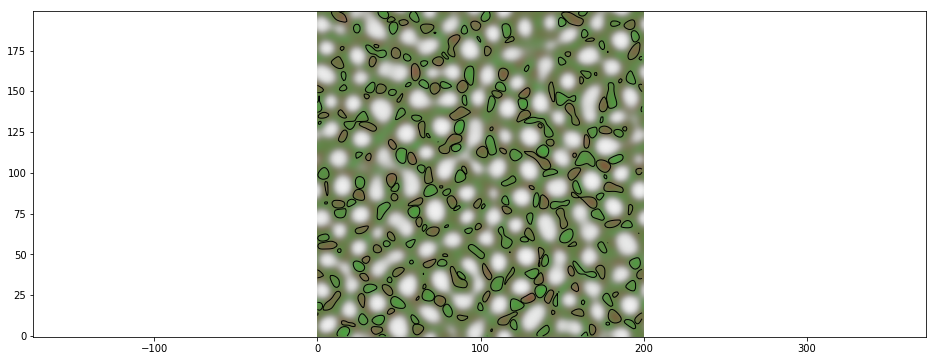

In [13]:
if 'is_test_run' not in globals():
    plt.phase_plot_for_step(ll)

## 2) Advection Test

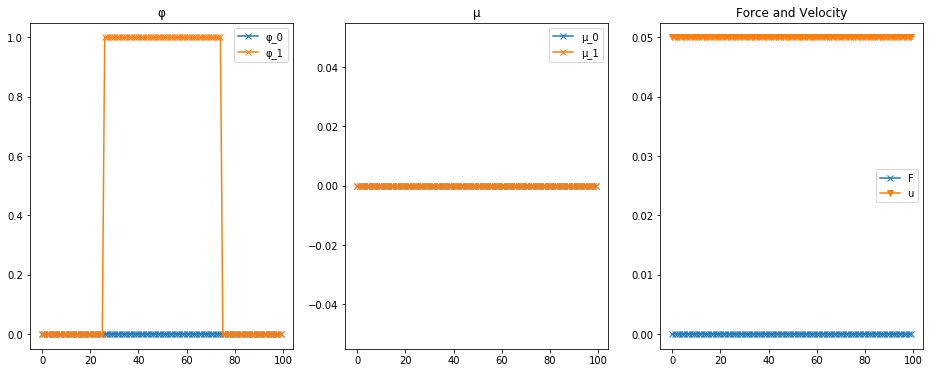

In [14]:
sc2 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                           num_phases=3, alpha=alpha)

ux = 0.05
phase_idx =1 
sc2.data_handling.fill(sc2.vel_field_name, ux, value_idx=0)
init_sharp_interface(sc2, phase_idx=phase_idx, inverse=False)

sc2.set_pdf_fields_from_macroscopic_values()
plot_status(sc2)

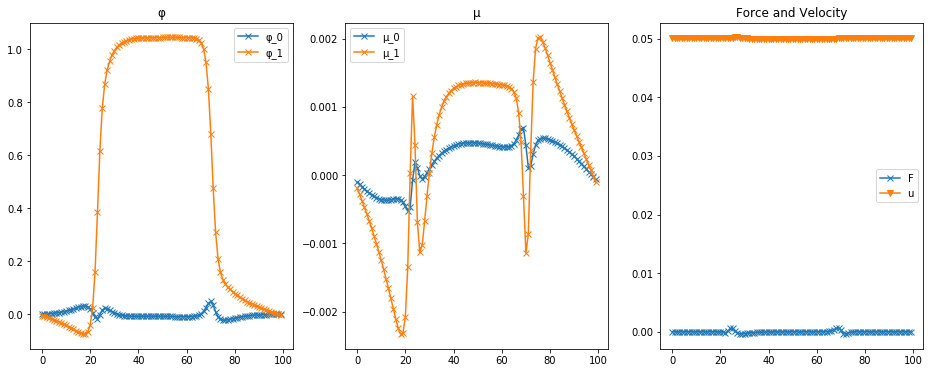

In [15]:
if 'is_test_run' in globals():
    sc2.run(1000)
else:
    sc2.run(10_000)
    assert abs(np.average(sc2.velocity[:, :, 0]) - 0.05) < 1e-10
plot_status(sc2)